# Exercise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

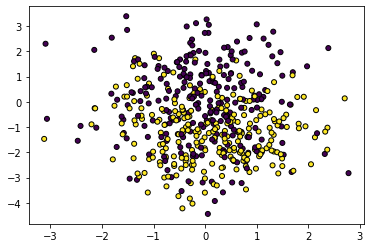

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#generate quite a lot of noise
#with only 4 informative features out of 10
#with 2 redundant features, overlapping with that 4 informative features
#and 4 noisy features
#Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#look at the data...it is likely not linearly separable!

In [3]:
#1
#implement Logistic Regression from scratch.  
#implement using Mini-Batch Gradient Descent which is basically using a subset of data
#Mini-Batch will be useful later on since Deep Learning folks loves Mini-Batch given its efficiency
#Mini-Batch is faster than Stochastic since it does not have
#to loop through all instances.  It is also faster than simple Gradient Descent
#since it does not have to look at the whole dataset in every update

In [4]:
#2
#implement KNN from scratch
#use Euclidean distance
#Idea is first write a function to compute distance
#Second, given X_test, try to find the nearest k neighbors, 
#by computing the distance between X_test and X_train
#then argsort them, you will find the nearest X_train neighbors
#Last, simply find the majority of class of these X_train neighbors
#and print the output

In [5]:
#3
#implement Naive Guassian Classification from scratch
#this one is a bit simple
#simply calculate the mean and variance of each class
#and calculate the probability density of each class
#using the Guassian Density function
#then for every point in X_test, whichever class probability
#is higher, then that point belongs to that class

In [6]:
#4
#implement a linear SVM from scratch using mini-batch-gradient descent
#implement the primal form (not dual form) - the one I teach in class
#primal form is usually preferred over dual form when
#simply copy the gradient() you have done with #1 and
#replace with the gradient of SVM and you should be almost done!
#one thing you need to be aware is that svm expect your y
#to be -1 and 1, not 0 or 1, or 1 or 2.
#last, get_pred should be np.sign(X @ w)

# Solution

In [7]:
#for all solution
intercept = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((intercept, X_train), axis=1)  #add intercept
intercept = np.ones((X_test.shape[0], 1))
X_test = np.concatenate((intercept, X_test), axis=1)  #add intercept

In [8]:
#1
import numpy as np
from sklearn.metrics import average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler

def mini_batch_GD(X, y, max_iter=1000):
    w = np.zeros(X.shape[1])
    l_rate = 0.01
    #10% of data
    batch_size = int(0.1 * X.shape[0])
    for i in range(max_iter):
        ix = np.random.randint(0, X.shape[0])
        batch_X = X[ix:ix+batch_size]
        batch_y = y[ix:ix+batch_size]
        w = w - l_rate * gradient(batch_X, batch_y, w)
    return w, i

#for those who tend to feel overwhelmed with lots of code
#I recommend you to write each part of the code separately as function
#it helps!
def gradient(X, y, w):
    m = X.shape[0]
    pred = get_pred(X, w)
    error = pred - y
    return (1/m) * np.dot(X.T, error)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
        
def get_pred(X, w):
    return sigmoid(X @ w)

def output(pred):
    return np.round(pred)

#LR is sensitive to outliers
#scaling can help remedy this issue
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

w, i = mini_batch_GD(X_train_standardized, y_train, max_iter=5000)

pred = output(get_pred(X_test_standardized, w))

print("APS: ", average_precision_score(y_test, pred))
print("Report: ", classification_report(y_test, pred))


APS:  0.7738275265628861
Report:                precision    recall  f1-score   support

           0       0.80      0.85      0.82        74
           1       0.85      0.79      0.82        76

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



In [9]:
#2
def find_distance(X_train, X_test):
    #broadcast B for each A
    #sum across feature dimension, thus axis = 2
    #can actually write one line
    dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
    sq_dist = dist ** 2
    summed_dist = sq_dist.sum(axis=2)
    sq_dist = np.sqrt(summed_dist)
    return sq_dist

def find_neighbors(X_train, X_test, k=3):
    dist = find_distance(X_train, X_test)
    #return the first k neighbors
    neighbors_ix = np.argsort(dist)[:, 0:k]
    return neighbors_ix
    
#https://numpy.org/doc/stable/reference/generated/numpy.bincount.html
def get_most_common(y):
    return np.bincount(y).argmax()

def predict(X_train, X_test, y_train, k=3):
    neighbors_ix = find_neighbors(X_train, X_test, k)
    pred = np.zeros(X_test.shape[0])
    for ix, y in enumerate(y_train[neighbors_ix]):
        pred[ix] = get_most_common(y)
    return pred

#cut intercept since KNN did not use
Xcut_train = np.delete(X_train, 0, 1)
Xcut_test = np.delete(X_test, 0, 1)

#if the training data is not scaled properly,
#since KNN is a distance algorithm, KNN will tend 
#to neglect small features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(Xcut_train)
X_test_standardized = scaler.transform(Xcut_test)

pred = predict(X_train_standardized, X_test_standardized, y_train, k=3)

print("APS: ", average_precision_score(y_test, pred))
print("Report: ", classification_report(y_test, pred))


APS:  0.7861956260514299
Report:                precision    recall  f1-score   support

           0       0.82      0.85      0.83        74
           1       0.85      0.82      0.83        76

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



In [10]:
#3
def mean_var(X_train, y_train):
    #dict keep mean and var of each class
    means = {}
    stds={}
    #calculate for every class the mean and std for every column
    for label in [0, 1]:
        means[label] = X_train[y_train==label].mean(axis=0)
        stds[label] =X_train[y_train==label].std(axis=0)
    return means, stds
    
#gaussian probability density function
#x is small x, refering to each point containing 2 features
#means is a vector of 2 mean for class 0 and 1
def gaussian_pdf(X, means, stds):
    left = 1/(np.sqrt(2*np.pi)*stds)
    e = (X-means)**2 / (2* (stds **2))
    right = np.exp(-e)
    return left*right

def predict(X_train, X_test, y_train):
    means, stds = mean_var(X_train, y_train)
    
    #guassian pdf for class 0 and 1
    pdf0 = gaussian_pdf(X_test, means[0], stds[0])
    pdf1 = gaussian_pdf(X_test, means[1], stds[1])
    
    #probability for class 0 and 1
    size0 = len(X_train[y_train==0])
    size1 = len(X_train[y_train==1])
    prob0 = size0 / (size0 + size1)
    prob1 = size1 / (size0 + size1)
        
    #np.product
    # P(feature1|class0) * P(feature2|class0)
    prob_x_given_y0 = np.prod(pdf0, axis=1)
    # P(feature1|class1) * P(feature2|class1)
    prob_x_given_y1 = np.prod(pdf1, axis=1)
    
    #P(class0) * P(feature1|class0) * P(feature2|class0)
    final_prob0 = prob0 * prob_x_given_y0    
    #P(class1) * P(feature1|class1) * P(feature2|class1)
    final_prob1 = prob1 * prob_x_given_y1
    
    #if probability of class 1 is more than 0, then True
    pred = 1 * final_prob1 > final_prob0
    
    return pred

#similar to KNN, cut intercept since we did not use
Xcut_train = np.delete(X_train, 0, 1)
Xcut_test = np.delete(X_test, 0, 1)

#if the training data is not scaled properly,
#similar to KNN, GNB is a distance algorithm, and will tend 
#to neglect small features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(Xcut_train)
X_test_standardized = scaler.transform(Xcut_test)

pred = predict(X_train_standardized, X_test_standardized, y_train)

print("APS: ", average_precision_score(y_test, pred))
print("Report: ", classification_report(y_test, pred))

APS:  0.85208545557442
Report:                precision    recall  f1-score   support

           0       0.81      0.96      0.88        74
           1       0.95      0.78      0.86        76

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



In [11]:
#4
import numpy as np
from sklearn.metrics import average_precision_score, classification_report

def mini_batch_GD(X, y, max_iter=1000):
    w = np.zeros(X.shape[1])
    l_rate = 0.00001
    batch_size = int(0.1 * X.shape[0])
    for i in range(max_iter):
        ix = np.random.randint(0, X.shape[0])
        batch_X = X[ix:ix+batch_size]
        batch_y = y[ix:ix+batch_size]
        #becareful the sign is "+" l_rate since i have already inverted 
        #the sign in gradient()
        for i, x in enumerate(batch_X):
            w = w + l_rate * gradient(batch_X[i], batch_y[i], w)
    return w, i

def gradient(x, y, w):
    lamb = 0.01
    if (y * (x @ w)) < 1:
        return (x * y) + (-2 * lamb * w)
    else:
        return -2 * lamb * w
        
def get_pred(X, w):
    #use np.sign if our input y is -1 and 1
    return np.sign(X @ w)

#transform our y to be -1 and 1 to meet svm purpose
y_train_minus = y_train.copy()
y_test_minus = y_test.copy()
y_train_minus[y_train_minus==0] = -1
y_test_minus[y_test_minus==0] = -1

#if the training data is not scaled properly,
#since svm is a widest street algorithm, SVM will tend 
#to neglect small features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

w, i = mini_batch_GD(X_train_standardized, y_train_minus, max_iter=10000)
pred = get_pred(X_test_standardized, w)

print("APS: ", average_precision_score(y_test_minus, pred))
print("Report: ", classification_report(y_test_minus, pred))


APS:  0.76765664160401
Report:                precision    recall  f1-score   support

          -1       0.79      0.85      0.82        74
           1       0.84      0.78      0.81        76

    accuracy                           0.81       150
   macro avg       0.82      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



In [12]:
#